<h1 align="center">Model selection</h1>

Libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import PredefinedSplit
import pyarrow.parquet as pq
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from utils import *
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb 

In [2]:
np.random.seed(12)

<h2 style="text-align: left;">Get and sample data</h2>

We start downloading the dataset from the STORAGE_PATH defined in utils.py and perform manual processing of it:

* We sample the dataset in half according to the orders to facilitate their processing and avoid memory problems.
* We filter the orders with more than 5 products given the specifications.
* We change the datatypes of the features associated with dates: order_data and created_at.

In [3]:
data = preprocess_data_manually()

Loading dataset from /home/oscar/data/feature_frame.csv
INFO:utils:Loading dataset from /home/oscar/data/feature_frame.csv


Original dataset size: (2880549, 27)
Sampled dataset size: (1442684, 27)


In order to enhance interpretability and facilitate variable manipulation, we explicitly define the variables

In [4]:
target = ['outcome']
id_features = ['variant_id', 'order_id', 'user_id']
temporal_features = ['created_at', 'order_date']
binary_features = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
categorical_features = ['product_type', 'vendor'] 
non_numerical_features = target + id_features+ temporal_features + categorical_features
numeric_features = [col for col in data.columns if col not in non_numerical_features]


<h2 style="text-align: left;">Train, validation and test splitting</h2>

In [5]:
final_data_sorted = data.sort_values(by='order_date')

train_end = final_data_sorted['order_date'].quantile(0.7)
val_end = final_data_sorted['order_date'].quantile(0.85)
test_end = final_data_sorted['order_date'].quantile(1)


train_data = final_data_sorted[final_data_sorted['order_date'] < train_end]
val_data = final_data_sorted[(final_data_sorted['order_date'] >= train_end) & (final_data_sorted['order_date'] < val_end)]
test_data = final_data_sorted[(final_data_sorted['order_date'] >= val_end) & (final_data_sorted['order_date'] <= test_end)]

print("Training set size:", (train_data.shape[0] / final_data_sorted.shape[0]))
print("Validation set size:", (val_data.shape[0] / final_data_sorted.shape[0]))
print("Testing set size:", (test_data.shape[0] / final_data_sorted.shape[0]))

Training set size: 0.6985001188930146
Validation set size: 0.1500164621097108
Testing set size: 0.1514834189972746


<h2 style="text-align: left;">Baseline</h2>

We define a logistic regression linear model with a regularization factor of 1e-4 using ridge regularization as our baseline. With this model, we achieve an area under the precision-recall curve (AUC_PR) of 0.16 and an area under the receiver operating characteristic curve (AUC_ROC) of 0.84. We use the four variables that were observed to have the highest predictive capability for this model.

The objective is to find a nonlinear model that allows us to improve these metrics according to the proposed business case

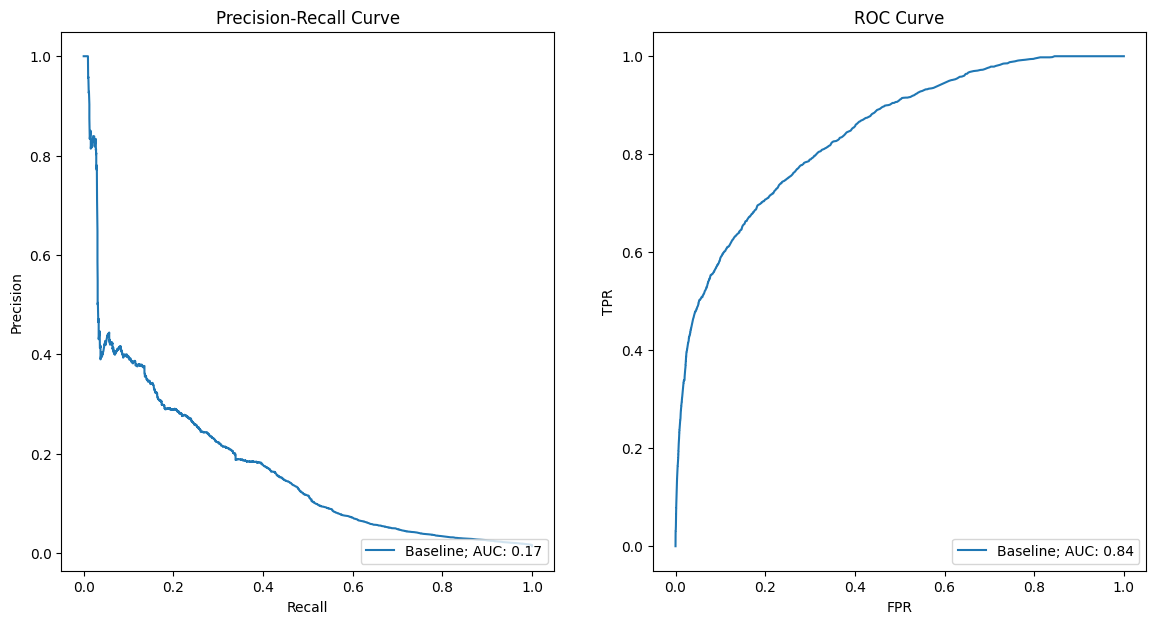

In [6]:
feature_cols = ["ordered_before", "abandoned_before", "global_popularity", "set_as_regular"]
target_col = "outcome"
baseline_model = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-4))

X_train_baseline, y_train_baseline = feature_label_split(feature_cols, target_col, train_data) 
X_val_baseline, y_val_baseline = feature_label_split(feature_cols, target_col, val_data) 

baseline_model.fit(X_train_baseline, y_train_baseline)
val_proba_baseline = baseline_model.predict_proba(X_val_baseline)[:, 1]
plot_metrics(f"Baseline", y_pred=val_proba_baseline, y_test=y_val_baseline)

<h2 style="text-align: left;">Decision trees</h2>

To take into account:
* **Insights on what is under the hood**: Decision trees are hierarchical structures composed of nodes, each representing a feature, and edges, representing decisions based on those features. At each node, the tree splits the data based on the feature that provides the most information gain. This process continues recursively until a stopping criterion is met.

* Decision trees have a tendency to have low bias but high variance, especially when they are deep or complex. However, with techniques like pruning or using ensemble methods like Random Forests, it's possible to reduce variance and control overfitting.

* **Are there caveats in the training process?**: Overfitting tendency.

* **Feature scale?**: Decision trees are invariant to the scale of the features and thus do not require feature scaling.

* **Training/inference times**: Decision tree training is generally fast, as the algorithm splits the data based on simple conditions at each node. However, inference time can be higher for deep or complex trees, especially when making predictions for large datasets.

* **Inductive biases**: Decision trees have inductive biases towards axis-aligned splits and tend to favor features with high information gain. This can make them effective for capturing certain types of patterns but may lead to suboptimal performance for datasets with complex relationships between features. Regularization techniques like pruning or using ensembles can help mitigate these biases.

We start with using only numerical variables, without taking into account the categorical ones at first, to see if it improves compared to the baseline.

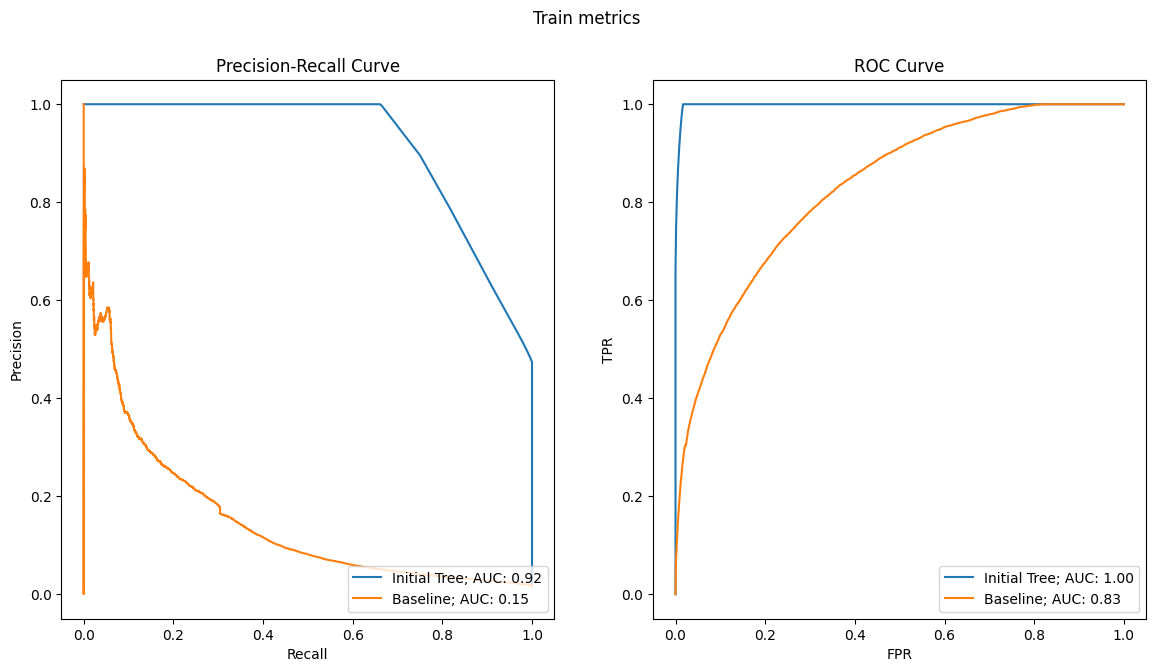

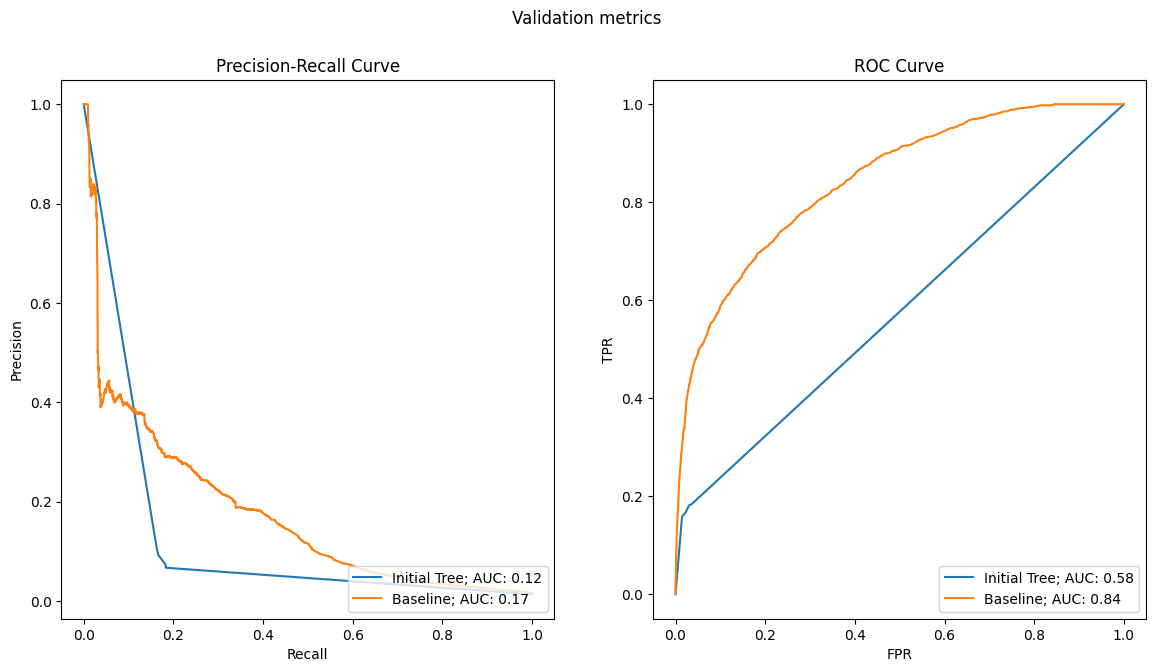

In [7]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

feature_cols = numeric_features
target_col = "outcome"
basic_tree = make_pipeline(tree.DecisionTreeClassifier())

X_train, y_train = feature_label_split(feature_cols, target_col, train_data) 
X_val, y_val = feature_label_split(feature_cols, target_col, val_data) 
X_test, y_test = feature_label_split(feature_cols, target_col, test_data) 

basic_tree.fit(X_train, y_train)
val_proba = basic_tree.predict_proba(X_val)[:, 1]
plot_metrics(f"Initial Tree", y_pred=basic_tree.predict_proba(X_train)[:, 1], y_test=y_train, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"Initial Tree", y_pred=basic_tree.predict_proba(X_val)[:, 1], y_test=y_val, figure=(fig2,ax2))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))


* As expected, the tree, without applying regularization techniques, overfits, resulting in an area under the precision-recall curve (AUC PR) of 0.93 on the training set and an AUC of 1 for the ROC curve.
* However, the results on the validation set are worse than the baseline, with an AUC PR of 0.12 and an AUC of the ROC of 0.57.
* The next step is to restrict the growth of the tree by using regularization techniques as min_samples_split, min_samples_leaf or max_depth

In [8]:
param_grid = {'min_samples_split': [0.05, 0.07],
              'min_samples_leaf': [0.02, 0.03],
              'max_depth': [8, 10]}

best_auc = 0
best_params = None

for min_samples_split in param_grid['min_samples_split']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        for max_depth in param_grid['max_depth']:

            clf = tree.DecisionTreeClassifier(criterion='gini',
                                         min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf,
                                         max_depth=max_depth,
                                         random_state=42)

            clf.fit(X_train, y_train)

            y_pred = clf.predict_proba(X_val)[:, 1]

            auc_score = roc_auc_score(y_val, y_pred)

            if auc_score > best_auc:
                best_auc = auc_score
                best_params = {'min_samples_split': min_samples_split,
                               'min_samples_leaf': min_samples_leaf,
                               'max_depth': max_depth}

print("Best AUC-ROC score:", best_auc)
print("Best parameters:", best_params)

Best AUC-ROC score: 0.8317250294879873
Best parameters: {'min_samples_split': 0.05, 'min_samples_leaf': 0.02, 'max_depth': 8}


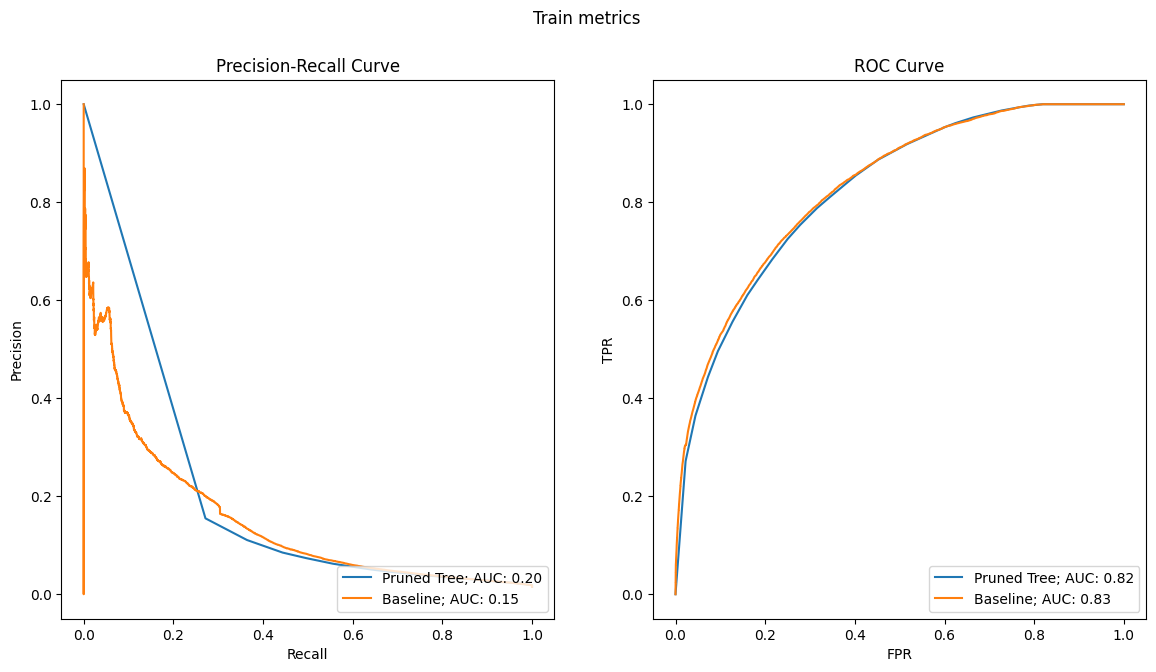

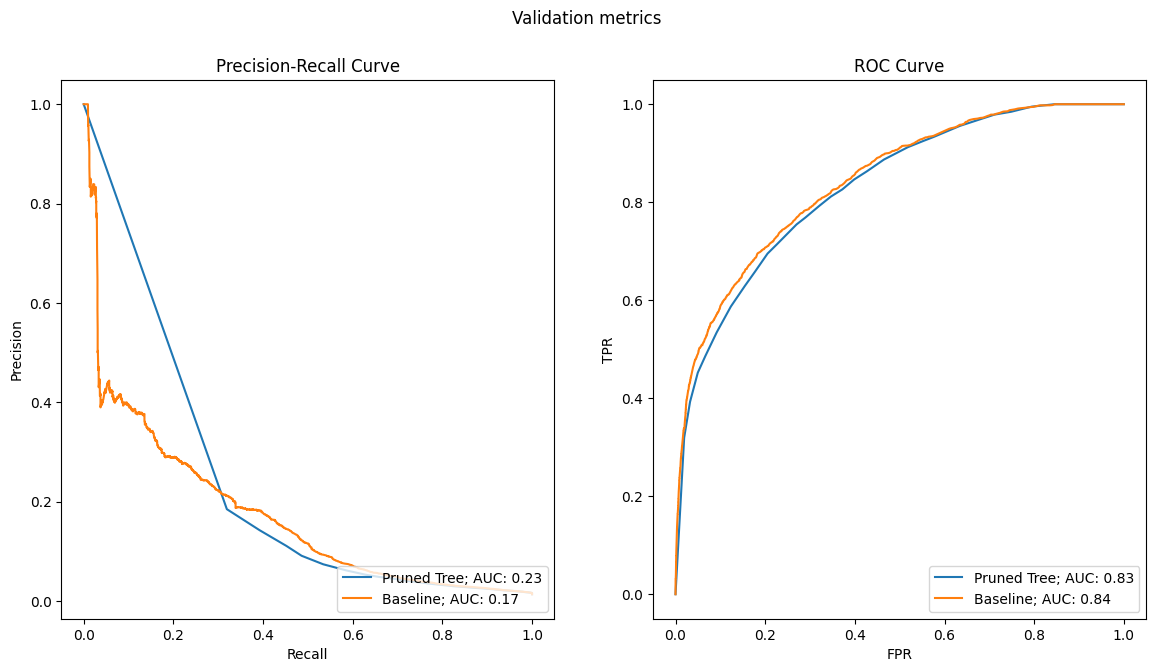

In [9]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

pruned_tree = tree.DecisionTreeClassifier(criterion='gini',
                                         min_samples_split=0.05,
                                         min_samples_leaf=0.02,
                                         max_depth=8,
                                         random_state=42)
pruned_tree.fit(X_train, y_train)

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_train)[:, 1], y_test=y_train, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_val)[:, 1], y_test=y_val, figure=(fig2,ax2))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))


Insights:
* The tree with added pre-pruning techniques improves the metrics of the baseline on the PR curve, which is the focus of our interest. This is particularly relevant because in the ROC curve, the true negative rate vastly outweighs the false positive rate, presenting a challenge that needs to be addressed.
* The metrics are consistent between train and test sets, indicating that overfitting, which appeared in the tree without pre-pruning, has been controlled.

The importance of variable ordered_before is: 77.43937
The importance of variable global_popularity is: 22.15201
The importance of variable std_days_to_buy_variant_id is: 0.12713
The importance of variable normalised_price is: 0.12459
The importance of variable avg_days_to_buy_product_type is: 0.06471
The importance of variable avg_days_to_buy_variant_id is: 0.0629
The importance of variable user_order_seq is: 0.02659
The importance of variable discount_pct is: 0.0027
The importance of variable abandoned_before is: 0.0
The importance of variable active_snoozed is: 0.0
The importance of variable set_as_regular is: 0.0
The importance of variable count_adults is: 0.0
The importance of variable count_children is: 0.0
The importance of variable count_babies is: 0.0
The importance of variable count_pets is: 0.0
The importance of variable people_ex_baby is: 0.0
The importance of variable days_since_purchase_variant_id is: 0.0
The importance of variable days_since_purchase_product_type is: 0.0

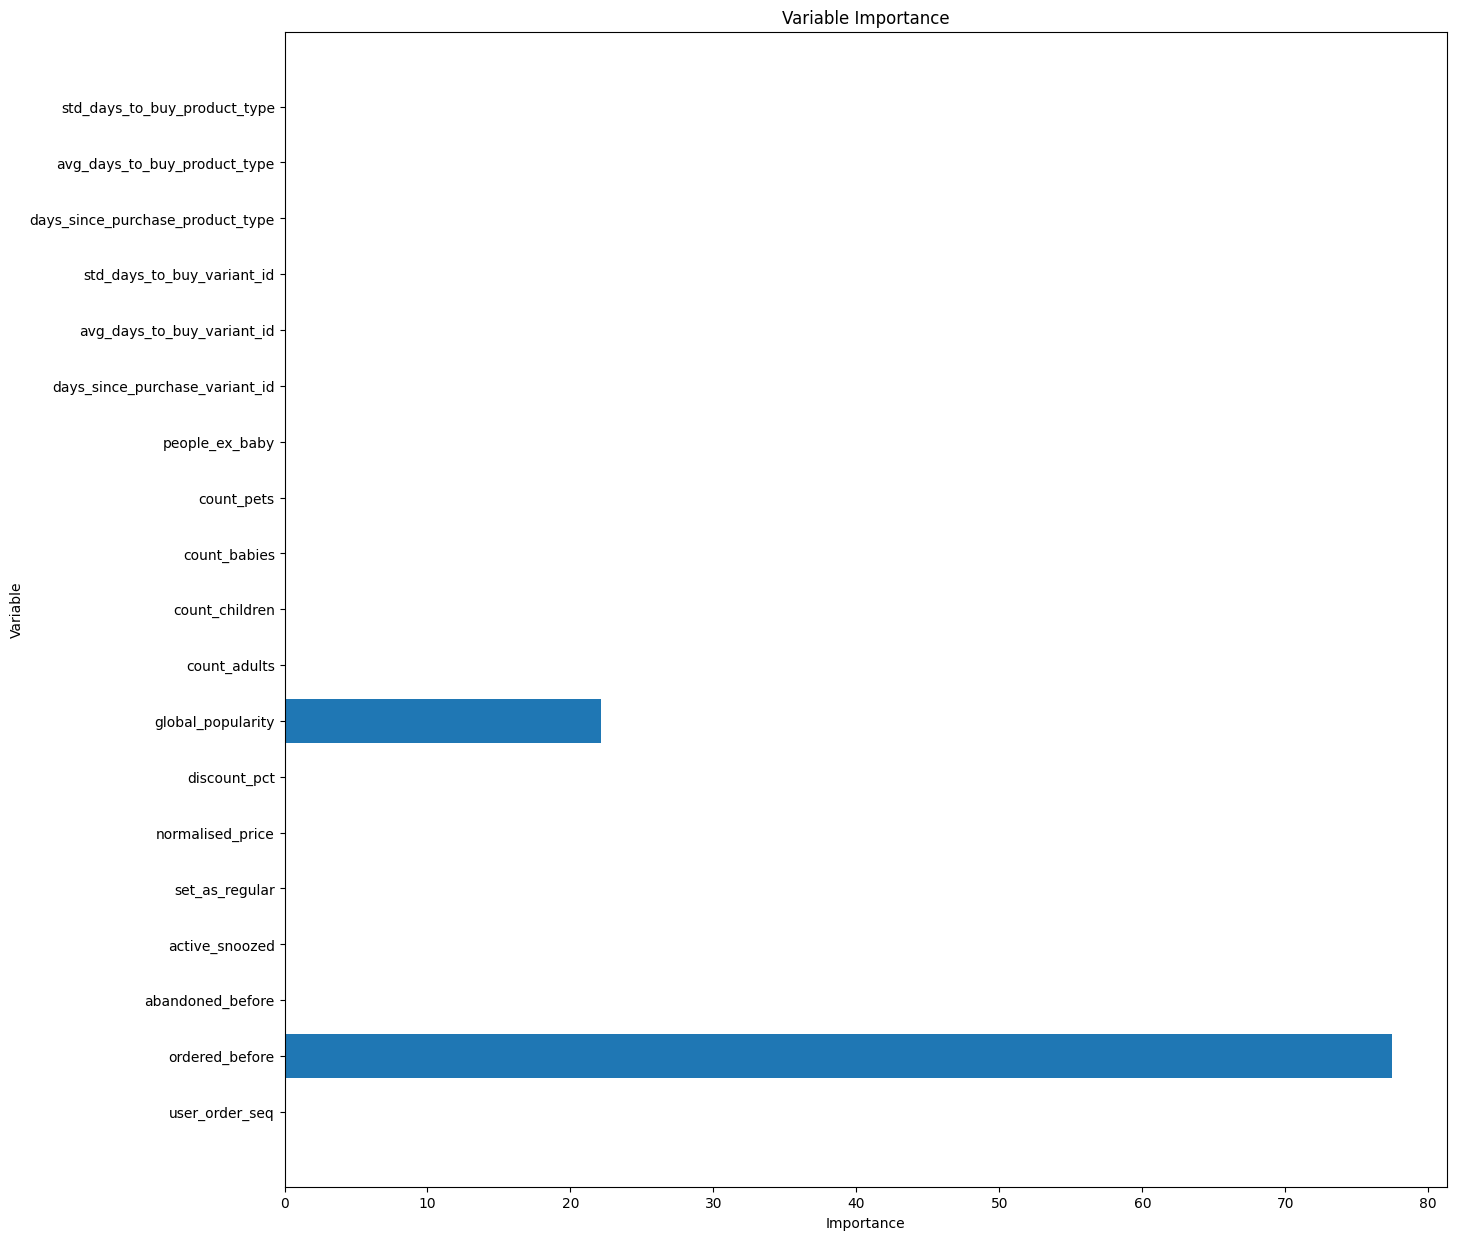

In [10]:
displayVariableImportance(pruned_tree, X_train.columns)

Based on these importance scores, it's suggested that lots of variables could be eliminated from further training.

<h2 style="text-align: left;">Random Forests</h2>

To take into account:
* Insights on what is under the hood: Random forests leverage the power of decision trees but with added randomness in the training process. Instead of relying on a single decision tree, random forests aggregate the predictions of multiple trees to arrive at a final prediction. During training, each tree is constructed using a bootstrap sample of the training data, meaning some observations may be sampled multiple times while others may not be included at all. Additionally, at each node in each tree, only a random subset of features is considered for splitting, further introducing diversity among the trees.

* Caveats in the training process: Caveats in the training process: It doesn't make sense to prune individual trees because the bias of the overall model corresponds to the worst bias among the individual trees, so it makes sense for them to grow indefinitely. Therefore, the parameter to consider is the number of independent trees, increasing which will reduce the overall variance. However, it's essential to note that too large a number of trees increases the correlation between them, reducing independence and worsening the process as well as the computational capacity.

* Feature scale: Similar to decision trees, random forests are invariant to the scale of the features and do not require feature scaling.

* Training/inference times: Training a random forest involves constructing multiple decision trees, which can be computationally intensive, especially for large datasets. 

* Inductive biases: Random forests inherit the inductive biases of decision trees, favoring axis-aligned splits and features with high information gain.

In [11]:
plt.figure(figsize=(10,8))

n_estimators = [25, 50, 100, 200]
RF_auc_pr_train_scores = []
RF_auc_pr_val_scores = []

for i, param in enumerate(n_estimators):
    RF = RandomForestClassifier(n_estimators = param, random_state = 42)

    RF.fit(X_train, y_train)
    pred_train = RF.predict_proba(X_train)[:, 1]
    pred_val = RF.predict_proba(X_val)[:, 1]
    
    RF_auc_pr_train_scores.append(evaluate_model(f"RF {param} estimators (train)", y_train, pred_train)[0])
    RF_auc_pr_val_scores.append(evaluate_model(f"RF {param} estimators (val)", y_val, pred_val)[0])


plt.plot(n_estimators, RF_auc_pr_train_scores, label = 'train_auc_pr')
plt.plot(n_estimators, RF_auc_pr_val_scores, label = 'val_auc_pr') 
plt.xlabel('n_estimators')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

RF 25 estimators (train) results:{PR AUC: 0.90, 'ROC AUC':1.00}
INFO:utils:RF 25 estimators (train) results:{PR AUC: 0.90, 'ROC AUC':1.00}
RF 25 estimators (val) results:{PR AUC: 0.12, 'ROC AUC':0.72}
INFO:utils:RF 25 estimators (val) results:{PR AUC: 0.12, 'ROC AUC':0.72}
RF 50 estimators (train) results:{PR AUC: 0.90, 'ROC AUC':1.00}
INFO:utils:RF 50 estimators (train) results:{PR AUC: 0.90, 'ROC AUC':1.00}
RF 50 estimators (val) results:{PR AUC: 0.13, 'ROC AUC':0.74}
INFO:utils:RF 50 estimators (val) results:{PR AUC: 0.13, 'ROC AUC':0.74}
RF 100 estimators (train) results:{PR AUC: 0.91, 'ROC AUC':1.00}
INFO:utils:RF 100 estimators (train) results:{PR AUC: 0.91, 'ROC AUC':1.00}
RF 100 estimators (val) results:{PR AUC: 0.13, 'ROC AUC':0.75}
INFO:utils:RF 100 estimators (val) results:{PR AUC: 0.13, 'ROC AUC':0.75}


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

* It seems that regardless of the number of estimators, the algorithm overfits when the rest of the parameters are kept as default, and there are no significant differences observed among the number of estimators.

* Potential solution? Reduce the number of samples taken for each tree. We'll investigate how this hyperparameter behaves with 100 trees.

RF 0.01 samples (train) results:{PR AUC: 0.20, 'ROC AUC':0.86}
INFO:utils:RF 0.01 samples (train) results:{PR AUC: 0.20, 'ROC AUC':0.86}
RF 0.01 samples (val) results:{PR AUC: 0.20, 'ROC AUC':0.81}
INFO:utils:RF 0.01 samples (val) results:{PR AUC: 0.20, 'ROC AUC':0.81}
RF 0.33666666666666667 samples (train) results:{PR AUC: 0.79, 'ROC AUC':1.00}
INFO:utils:RF 0.33666666666666667 samples (train) results:{PR AUC: 0.79, 'ROC AUC':1.00}
RF 0.33666666666666667 samples (val) results:{PR AUC: 0.17, 'ROC AUC':0.78}
INFO:utils:RF 0.33666666666666667 samples (val) results:{PR AUC: 0.17, 'ROC AUC':0.78}
RF 0.6633333333333333 samples (train) results:{PR AUC: 0.89, 'ROC AUC':1.00}
INFO:utils:RF 0.6633333333333333 samples (train) results:{PR AUC: 0.89, 'ROC AUC':1.00}
RF 0.6633333333333333 samples (val) results:{PR AUC: 0.14, 'ROC AUC':0.76}
INFO:utils:RF 0.6633333333333333 samples (val) results:{PR AUC: 0.14, 'ROC AUC':0.76}
RF 0.99 samples (train) results:{PR AUC: 0.91, 'ROC AUC':1.00}
INFO:utils:

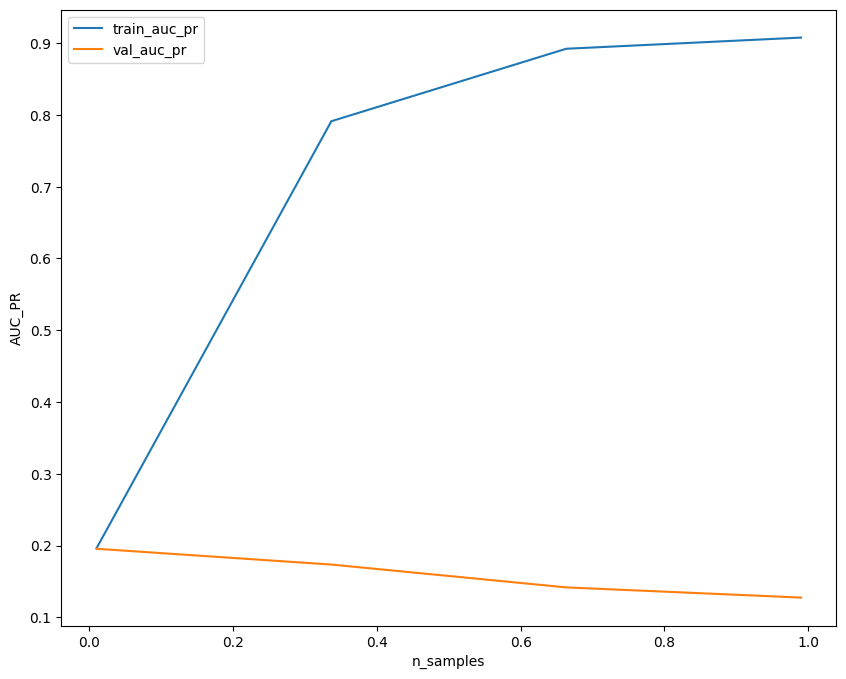

In [12]:
plt.figure(figsize=(10,8))

max_samples = np.linspace(0.01, 0.99, 4)
RF_auc_pr_train_scores = []
RF_auc_pr_val_scores = []

for i, param in enumerate(max_samples):
    RF = RandomForestClassifier(max_samples = param, random_state = 42)

    RF.fit(X_train, y_train)
    pred_train = RF.predict_proba(X_train)[:, 1]
    pred_val = RF.predict_proba(X_val)[:, 1]
    
    RF_auc_pr_train_scores.append(evaluate_model(f"RF {param} samples (train)", y_train, pred_train)[0])
    RF_auc_pr_val_scores.append(evaluate_model(f"RF {param} samples (val)", y_val, pred_val)[0])


plt.plot(max_samples, RF_auc_pr_train_scores, label = 'train_auc_pr')
plt.plot(max_samples, RF_auc_pr_val_scores, label = 'val_auc_pr') 
plt.xlabel('n_samples')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

* As we increase the max_samples, the model tends to overfit more because it reduces the independence between the trees.
* It seems that using 0.01 as the hyperparameter could be a good option since the model doesn't overfit, and we could further adjust the number of trees.

RF 1 estimators (train) results:{PR AUC: 0.12, 'ROC AUC':0.55}
INFO:utils:RF 1 estimators (train) results:{PR AUC: 0.12, 'ROC AUC':0.55}
RF 1 estimators (val) results:{PR AUC: 0.11, 'ROC AUC':0.55}
INFO:utils:RF 1 estimators (val) results:{PR AUC: 0.11, 'ROC AUC':0.55}
RF 51 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.82}
INFO:utils:RF 51 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.82}
RF 51 estimators (val) results:{PR AUC: 0.18, 'ROC AUC':0.79}
INFO:utils:RF 51 estimators (val) results:{PR AUC: 0.18, 'ROC AUC':0.79}
RF 101 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.86}
INFO:utils:RF 101 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.86}
RF 101 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.81}
INFO:utils:RF 101 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.81}
RF 151 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.87}
INFO:utils:RF 151 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.87}
RF 151 estimators (val) results:{PR A

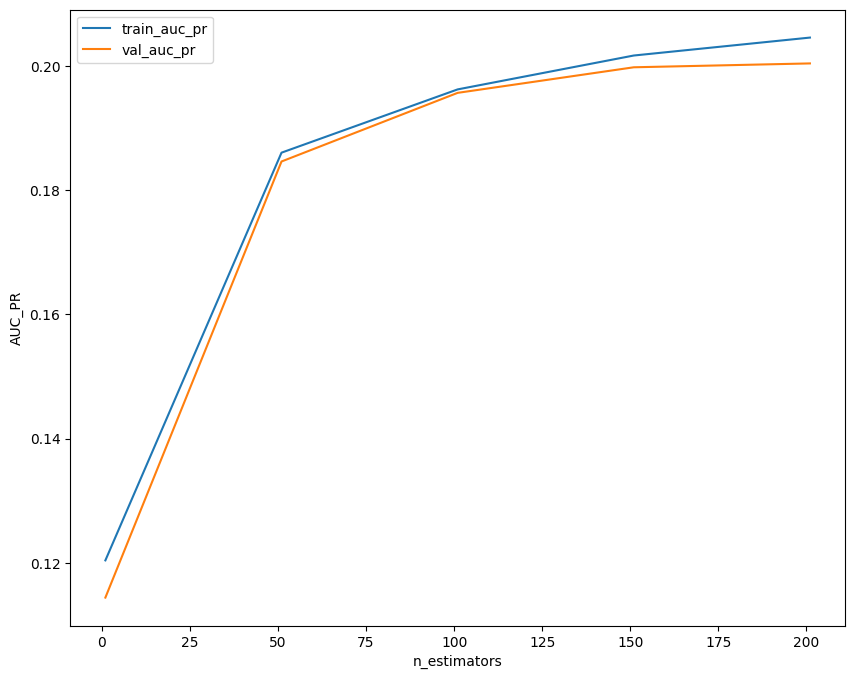

In [ ]:
plt.figure(figsize=(10,8))

n_estimators = np.arange(1,250,50)
RF_auc_pr_train_scores = []
RF_auc_pr_val_scores = []

for i, param in enumerate(n_estimators):
    RF = RandomForestClassifier(n_estimators = param, max_samples = 0.01, random_state = 42)

    RF.fit(X_train, y_train)
    pred_train = RF.predict_proba(X_train)[:, 1]
    pred_val = RF.predict_proba(X_val)[:, 1]
    
    RF_auc_pr_train_scores.append(evaluate_model(f"RF {param} estimators (train)", y_train, pred_train)[0])
    RF_auc_pr_val_scores.append(evaluate_model(f"RF {param} estimators (val)", y_val, pred_val)[0])


plt.plot(n_estimators, RF_auc_pr_train_scores, label = 'train_auc_pr')
plt.plot(n_estimators, RF_auc_pr_val_scores, label = 'val_auc_pr') 
plt.xlabel('n_estimators')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

* It seems that a random forest with a max_samples parameter of 0.01 and a number of trees of 100 could be the best option to have trees that are sufficiently independent from each other (considering they are not completely independent). 
* For smaller values of n_estimators, worse metrics are provided compared to the baseline, and above 100 trees, the trees start to become correlated with each other, leading to differences in metrics between training and validation sets.

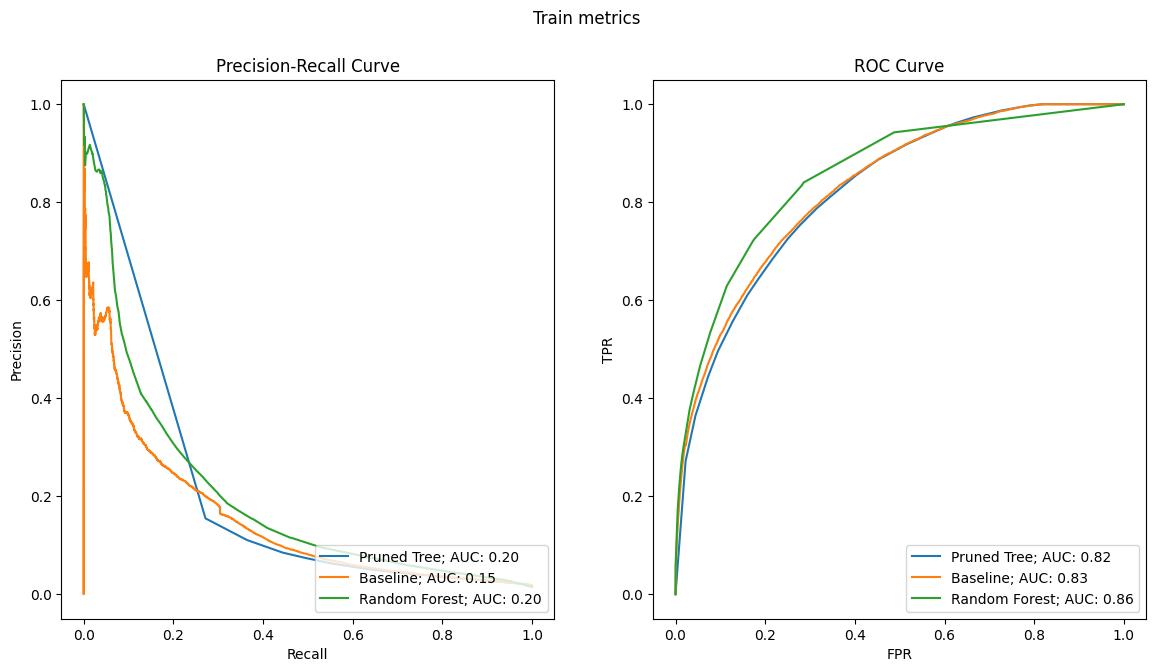

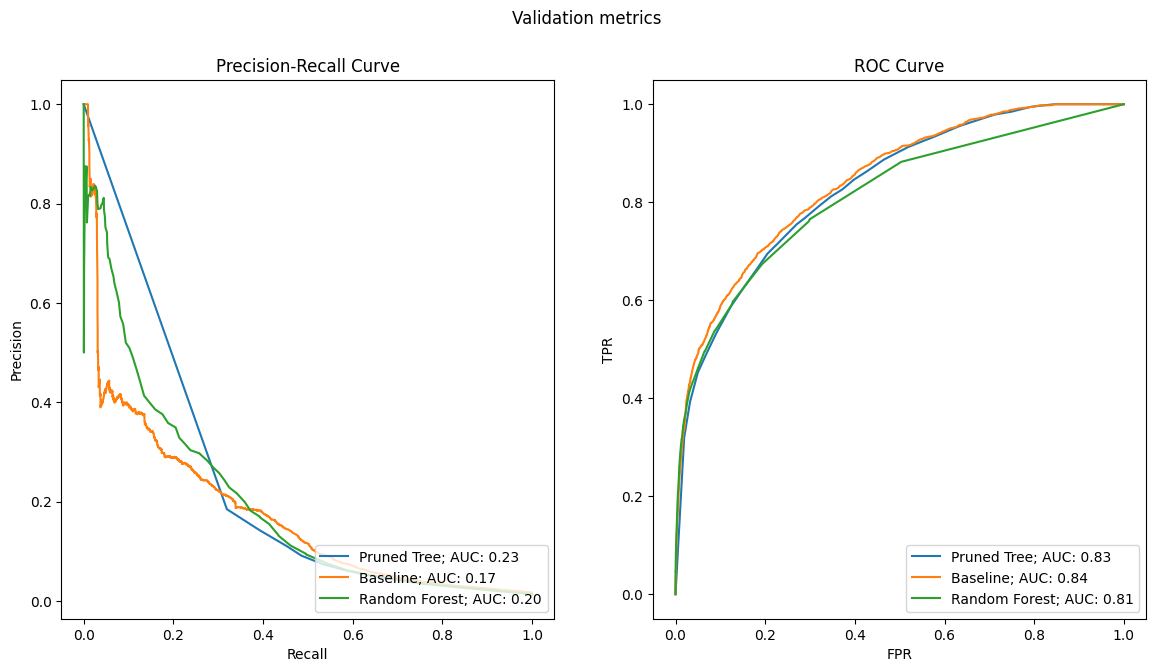

In [13]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

RF = RandomForestClassifier(n_estimators = 100, max_samples = 0.01, random_state = 42)
RF.fit(X_train, y_train)

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_train)[:, 1], y_test=y_train, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"Random Forest", y_pred = RF.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_val)[:, 1], y_test=y_val, figure=(fig2,ax2))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))
plot_metrics(f"Random Forest", y_pred = RF.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))

Insights:

* We have discovered a random forest with metrics superior to the baseline for 100 trees and a max_samples of 0.01, indicating the number of examples each resampling will have. This combination of hyperparameters achieves such performance because it enhances the independence among trees.

* Increasing the number of estimators causes them to become correlated with each other, and it fails to reduce variance as effectively.

* Utilizing all samples, as done by the default algorithm (max_samples = 1), deteriorates the independence among trees, while 'auto' is used for max_features.

* The remaining variables, which pruning techniques for the tree employ, are not utilized because it's necessary for individual trees to overfit in order to introduce diversity into the problem.

* Drawbacks compared to decision trees include higher computational complexity and loss of interpretability.


A Random Forest has been found whose performance is better than the baseline. However, the previously developed decision tree achieves better metrics.

<h2 style="text-align: left;">Gradient Boosting</h2>

To take into account:

* Insights on what is under the hood: Gradient Boosting is an ensemble technique that sequentially builds an additive model, where each new model corrects the errors made by the previous ones. In each iteration, a new model is fitted to predict the residuals of the previous model, and then added to the ensemble. This process is repeated until a certain number of iterations is reached or until a predefined loss function is minimized.

* Caveats in the training process: In Gradient Boosting, it's crucial to tune hyperparameters such as the learning rate and tree depth to prevent overfitting, as the trees can grow too large and overfit to the training data. Unlike Random Forests, where individual trees are built independently, each new tree in Gradient Boosting is adjusted to improve the overall performance of the ensemble. 

* Feature scale: Similar to Random Forests, Gradient Boosting is insensitive to feature scaling, as it relies on decision trees that are not affected by the scale of the features.

* Training/inference times: Training time in Gradient Boosting can be slower compared to Random Forests, especially when using complex decision trees or large datasets. However, inference time tends to be faster due to the sequential and additive structure of the model.

* Inductive biases: Inductive biases in Gradient Boosting include a preference for simpler models and the ability to capture non-linear relationships between features. Additionally, the ordering dependence of features can influence the model's ability to capture patterns in the data.

**1. Determining the number of estimators** 

Let's keep the learning rate constant to observe how performance varies based on the number of estimators. Increasing the number of estimators in Gradient Boosting introduces more regularization to the model.

GB 1 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.77}
INFO:utils:GB 1 estimators (train) results:{PR AUC: 0.20, 'ROC AUC':0.77}
GB 1 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.77}
INFO:utils:GB 1 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.77}
GB 51 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
INFO:utils:GB 51 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
GB 51 estimators (val) results:{PR AUC: 0.16, 'ROC AUC':0.84}
INFO:utils:GB 51 estimators (val) results:{PR AUC: 0.16, 'ROC AUC':0.84}
GB 101 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
INFO:utils:GB 101 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
GB 101 estimators (val) results:{PR AUC: 0.16, 'ROC AUC':0.84}
INFO:utils:GB 101 estimators (val) results:{PR AUC: 0.16, 'ROC AUC':0.84}
GB 151 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
INFO:utils:GB 151 estimators (train) results:{PR AUC: 0.19, 'ROC AUC':0.84}
GB 151 estimators (val) results:{PR A

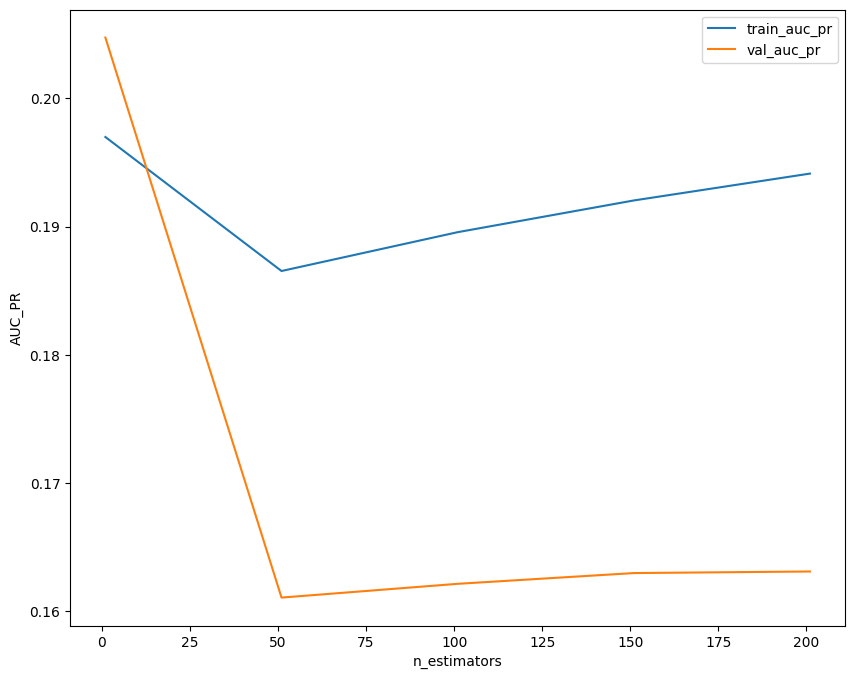

In [30]:
plt.figure(figsize=(10,8))

n_estimators = [1, 25, 50, 75, 100, 150, 200]
GB_auc_pr_train_scores = []
GB_auc_pr_val_scores = []

for i, param in enumerate(n_estimators):
    GB = GradientBoostingClassifier(n_estimators = param, random_state = 42)

    GB.fit(X_train, y_train)
    pred_train = GB.predict_proba(X_train)[:, 1]
    pred_val = GB.predict_proba(X_val)[:, 1]
    
    GB_auc_pr_train_scores.append(evaluate_model(f"GB {param} estimators (train)", y_train, pred_train)[0])
    GB_auc_pr_val_scores.append(evaluate_model(f"GB {param} estimators (val)", y_val, pred_val)[0])


plt.plot(n_estimators, GB_auc_pr_train_scores, label = 'train_auc_pr')
plt.plot(n_estimators, GB_auc_pr_val_scores, label = 'val_auc_pr') 
plt.xlabel('n_estimators')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

Keeping all hyperparameters constant except for the number of trees to use, there are no significant differences in the metrics obtained, so we will take **25 trees**. Let's see if there are differences with 'max_depth'. As 'max_depth' increases, the variance tends to increase.

**2. Tuning the parameters specific to the tree (max depth)**

GB max_depth=1 (train) results:{PR AUC: 0.16, 'ROC AUC':0.82}
INFO:utils:GB max_depth=1 (train) results:{PR AUC: 0.16, 'ROC AUC':0.82}
GB max_depth=1 (val) results:{PR AUC: 0.17, 'ROC AUC':0.82}
INFO:utils:GB max_depth=1 (val) results:{PR AUC: 0.17, 'ROC AUC':0.82}
GB max_depth=3 (train) results:{PR AUC: 0.18, 'ROC AUC':0.83}
INFO:utils:GB max_depth=3 (train) results:{PR AUC: 0.18, 'ROC AUC':0.83}
GB max_depth=3 (val) results:{PR AUC: 0.21, 'ROC AUC':0.84}
INFO:utils:GB max_depth=3 (val) results:{PR AUC: 0.21, 'ROC AUC':0.84}
GB max_depth=5 (train) results:{PR AUC: 0.21, 'ROC AUC':0.84}
INFO:utils:GB max_depth=5 (train) results:{PR AUC: 0.21, 'ROC AUC':0.84}
GB max_depth=5 (val) results:{PR AUC: 0.21, 'ROC AUC':0.85}
INFO:utils:GB max_depth=5 (val) results:{PR AUC: 0.21, 'ROC AUC':0.85}
GB max_depth=7 (train) results:{PR AUC: 0.25, 'ROC AUC':0.85}
INFO:utils:GB max_depth=7 (train) results:{PR AUC: 0.25, 'ROC AUC':0.85}
GB max_depth=7 (val) results:{PR AUC: 0.16, 'ROC AUC':0.85}
INFO:ut

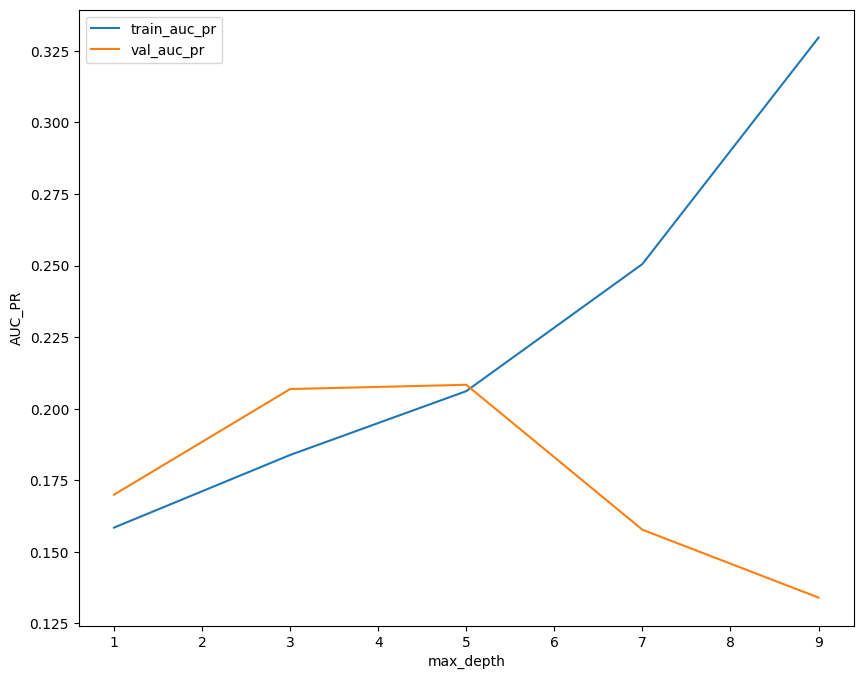

In [36]:
plt.figure(figsize=(10, 8))

max_depths = np.arange(1, 11, 2)
GB_auc_pr_train_scores = []
GB_auc_pr_val_scores = []

for depth in max_depths:
    GB = GradientBoostingClassifier(max_depth=depth, n_estimators = 25, random_state=42)

    GB.fit(X_train, y_train)
    pred_train = GB.predict_proba(X_train)[:, 1]
    pred_val = GB.predict_proba(X_val)[:, 1]

    GB_auc_pr_train_scores.append(evaluate_model(f"GB max_depth={depth} (train)", y_train, pred_train)[0])
    GB_auc_pr_val_scores.append(evaluate_model(f"GB max_depth={depth} (val)", y_val, pred_val)[0])

plt.plot(max_depths, GB_auc_pr_train_scores, label='train_auc_pr')
plt.plot(max_depths, GB_auc_pr_val_scores, label='val_auc_pr')
plt.xlabel('max_depth')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

It seems that max_depth = 5 could be a good choice.

**3. Tuning the learning rate**

In [39]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.25, 1, 10]}

best_auc = 0
best_params = None

for learning_rate in param_grid['learning_rate']:

    GB = GradientBoostingClassifier(max_depth=5, n_estimators = 25, random_state=42, learning_rate=learning_rate)

    GB.fit(X_train, y_train)

    y_pred = GB.predict_proba(X_val)[:, 1]

    auc_score = roc_auc_score(y_val, y_pred)

    if auc_score > best_auc:
        best_auc = auc_score
        best_params = {'learning_rate': learning_rate}

print("Best AUC-ROC score:", best_auc)
print("Best parameters:", best_params)

Best AUC-ROC score: 0.8490134664762521
Best parameters: {'learning_rate': 0.1}


Final Model Gradient Boosting Tree and Comparition

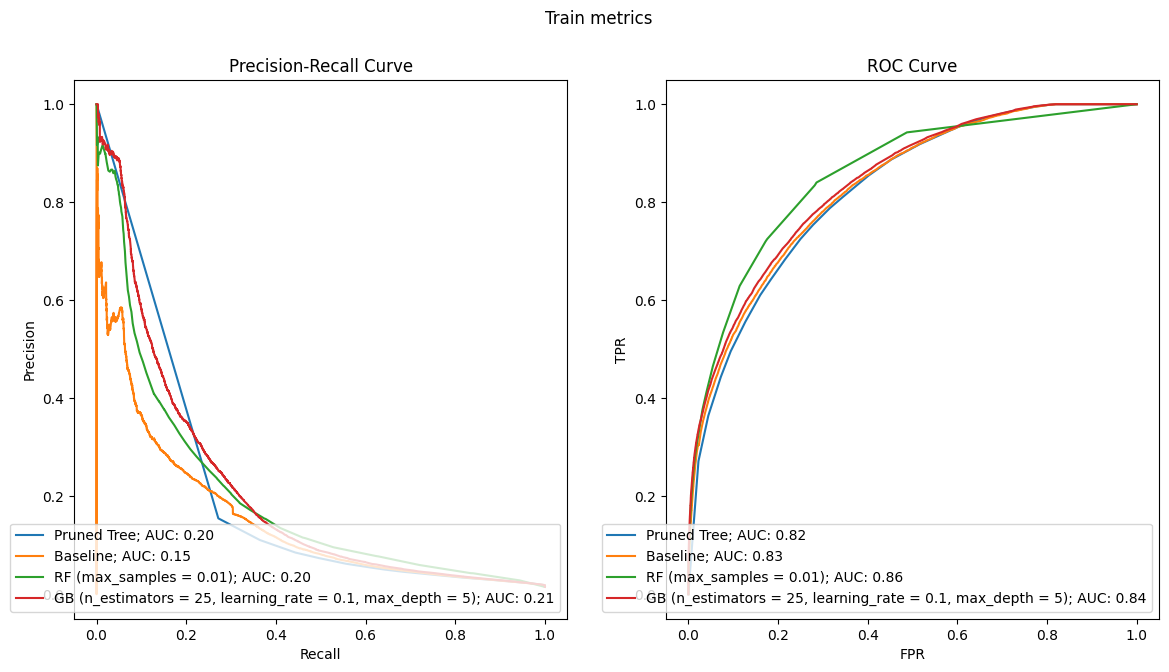

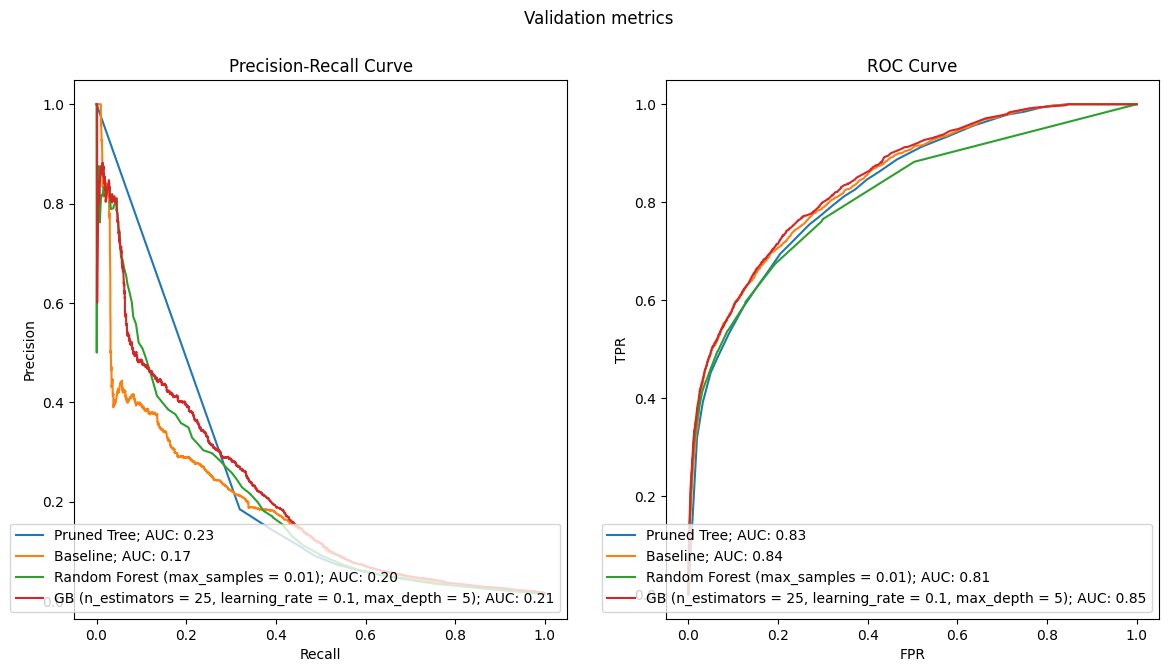

In [40]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

GB = GradientBoostingClassifier(learning_rate=0.1, max_depth= 5, n_estimators= 25, random_state=42)
GB.fit(X_train, y_train)

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_train)[:, 1], y_test=y_train, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"RF (max_samples = 0.01)", y_pred = RF.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))
plot_metrics(f"GB (n_estimators = 25, learning_rate = 0.1, max_depth = 5)", y_pred = GB.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_val)[:, 1], y_test=y_val, figure=(fig2,ax2))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))
plot_metrics(f"Random Forest (max_samples = 0.01)", y_pred = RF.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))
plot_metrics(f"GB (n_estimators = 25, learning_rate = 0.1, max_depth = 5)", y_pred = GB.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))

<h2 style="text-align: left;">XG Boost</h2>

To take into account:

* **Insights on what is under the hood**: XGBoost, or Extreme Gradient Boosting, is an advanced implementation of gradient boosting that employs a more regularized model formulation to control overfitting. Similar to traditional gradient boosting, XGBoost sequentially builds an ensemble of weak learners, typically decision trees, where each subsequent model corrects the errors made by the previous ones. However, XGBoost introduces additional regularization terms in the objective function, such as L1 and L2 regularization, to penalize complexity and prevent overfitting more effectively.

* **Caveats in the training process**: When training XGBoost models, it's essential to carefully tune hyperparameters such as the learning rate, tree depth, and regularization parameters. The learning rate controls the step size at each iteration and influences the contribution of each tree to the ensemble. Setting a high learning rate may lead to faster convergence but increases the risk of overshooting the optimal solution. Conversely, a low learning rate may require more iterations to converge but can yield better generalization performance. Additionally, adjusting the tree depth and regularization parameters, such as max_depth, min_child_weight, gamma, lambda, and alpha, is crucial to prevent overfitting and achieve optimal model complexity.

* **Feature scale**: Similar to other tree-based models like Random Forests, XGBoost is insensitive to feature scaling. Since decision trees make splits based on feature values without considering their scale, the performance of XGBoost remains unchanged regardless of whether the features are scaled or not.

* **Training/inference times**: Training an XGBoost model can be computationally intensive, especially when using large datasets or complex models with deep trees and many features. However, XGBoost offers several optimization techniques, such as parallelized tree construction and approximate algorithms for split finding, to improve training efficiency. Inference time tends to be fast, as making predictions with an already trained XGBoost model involves traversing the ensemble of trees and computing the final prediction.

* **Inductive biases**: XGBoost inherits the inductive biases of gradient boosting, favoring simpler models and capturing non-linear relationships between features. Additionally, XGBoost introduces regularization terms in the objective function to control model complexity and prevent overfitting more effectively. The ordering dependence of features also influences the model's ability to capture patterns in the data, as XGBoost sequentially builds an additive model and adjusts each new tree to minimize the overall loss of the ensemble.

We start from a predefined XGBoost model from which we will try to improve its hyperparameters to find the best possible performance.

In [31]:
xgboost = xgb.XGBClassifier(
 learning_rate =0.25,
 max_depth=5,
 n_estimators = 100,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 eval_metric='logloss',
 scale_pos_weight=1,
 use_label_encoder=False,
 seed=27)

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

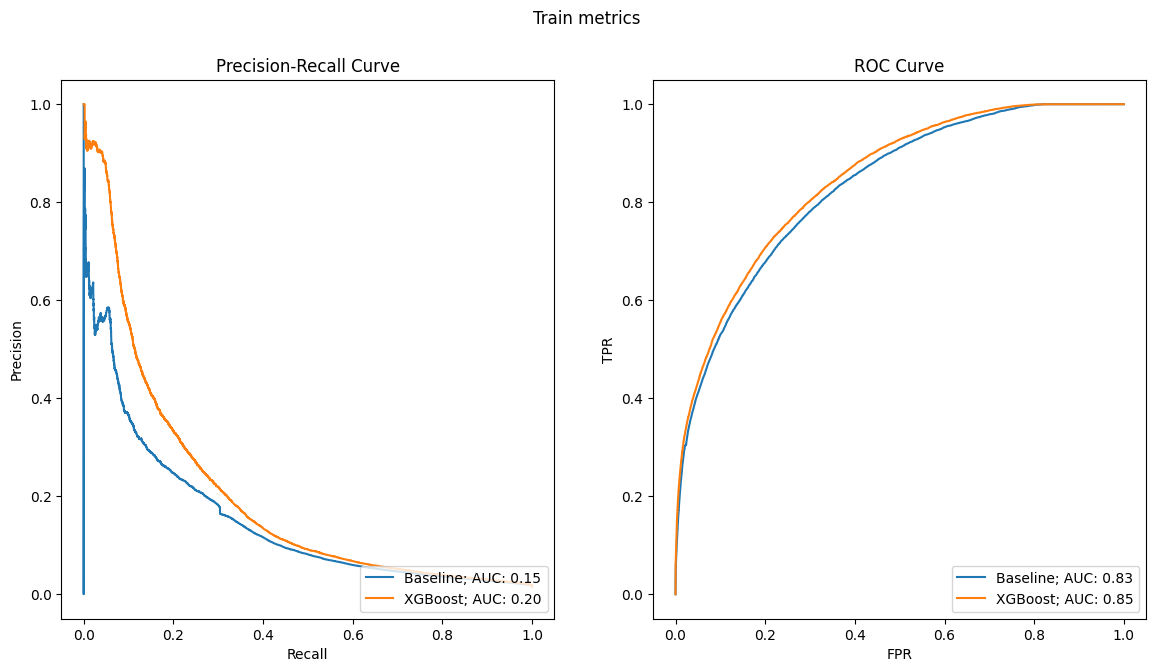

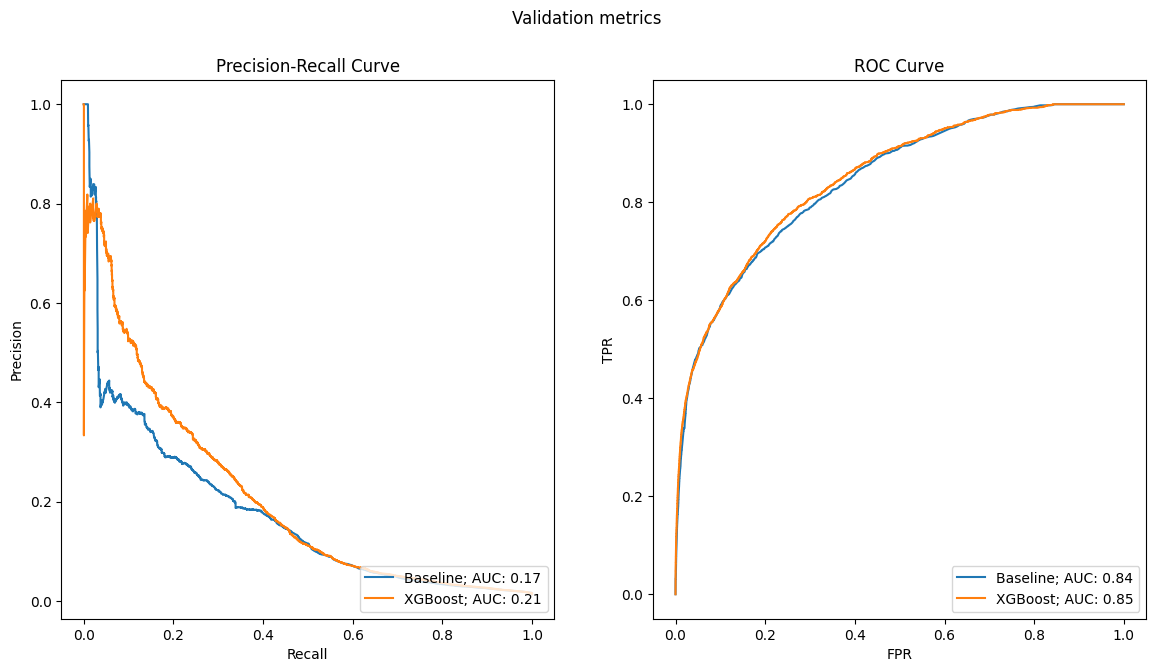

In [32]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))

plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))
plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))

As can be observed, the predefined XGBoost model already outperforms the logistic regression baseline, making it a good starting point for improvement. In this context, we will follow the following order:

1. Optimization of the number of trees
2. Optimization of the hyperparameters of each tree
3. Optimization of the regularization parameters gamma and alpha
4. Optimization of the learning rate

1. **Optimization of the number of trees**

XGBoost 1 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
INFO:utils:XGBoost 1 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
XGBoost 1 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
INFO:utils:XGBoost 1 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
XGBoost 5 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
INFO:utils:XGBoost 5 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
XGBoost 5 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
INFO:utils:XGBoost 5 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
XGBoost 10 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
INFO:utils:XGBoost 10 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
XGBoost 10 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
INFO:utils:XGBoost 10 estimators (val) results:{PR AUC: 0.20, 'ROC AUC':0.84}
XGBoost 25 estimators (train) results:{PR AUC: 0.24, 'ROC AUC':0.86}
INFO:utils:XGBoost 25 estimators (train) results:{PR AUC:

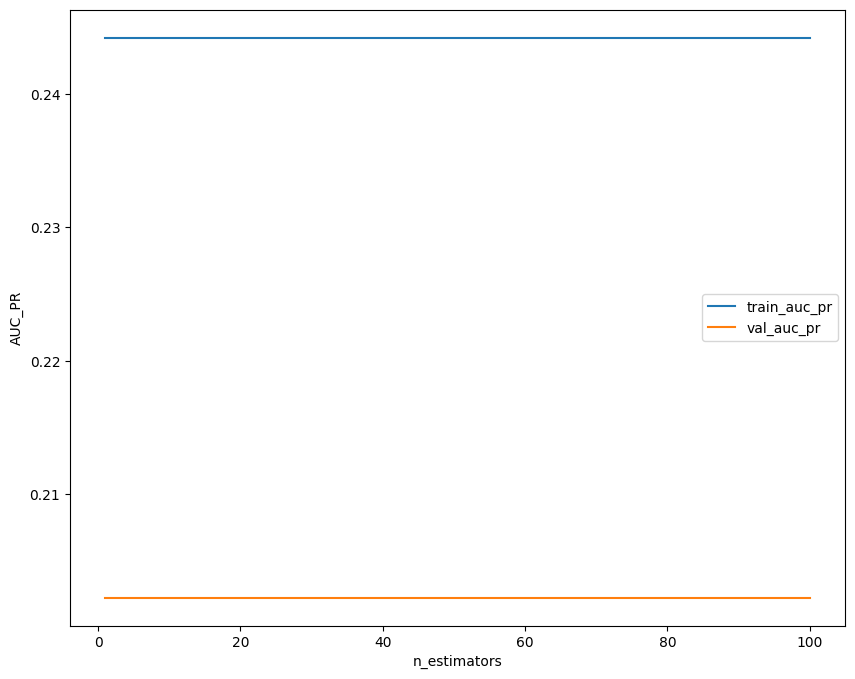

In [26]:
plt.figure(figsize=(10,8))

n_estimators = [1, 5, 10, 25, 50 ,100]
XGB_auc_pr_train_scores = []
XGB_auc_pr_val_scores = []

for i, param in enumerate(n_estimators):
    

    xgboost.fit(X_train, y_train)
    pred_train = xgboost.predict_proba(X_train)[:, 1]
    pred_val = xgboost.predict_proba(X_val)[:, 1]
    
    XGB_auc_pr_train_scores.append(evaluate_model(f"XGBoost {param} estimators (train)", y_train, pred_train)[0])
    XGB_auc_pr_val_scores.append(evaluate_model(f"XGBoost {param} estimators (val)", y_val, pred_val)[0])


plt.plot(n_estimators, XGB_auc_pr_train_scores, label = 'train_auc_pr')
plt.plot(n_estimators, XGB_auc_pr_val_scores, label = 'val_auc_pr') 
plt.xlabel('n_estimators')
plt.ylabel('AUC_PR')
plt.legend()
plt.show()

Commenting on the performance, as the number of estimators increases, it remains constant, we'll choose n_estimators = 100, which is the defauls value.

**2. Optimization of the hyperparameters of each tree**

In [33]:
param_grid = {'max_depth': [3,6,9],
             'min_child_weight': [1,3,5]}

best_auc = 0
best_params = None


for min_child_weight in param_grid['min_child_weight']:
    for max_depth in param_grid['max_depth']:

        xgboost = xgb.XGBClassifier(
        learning_rate =0.25,
        max_depth=max_depth,
        n_estimators = 100,
        min_child_weight=min_child_weight,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=1,
        use_label_encoder=False,
        seed=27)

        xgboost.fit(X_train, y_train)

        y_pred = xgboost.predict_proba(X_val)[:, 1]

        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        pr_auc = auc(recall, precision)

        if pr_auc > best_auc:
            best_auc = pr_auc
            best_params = {'min_child_weight': min_child_weight,
                            'max_depth': max_depth}

print("Best AUC-PR score:", best_auc)
print("Best parameters:", best_params)

Best AUC-PR score: 0.20718802599732095
Best parameters: {'min_child_weight': 3, 'max_depth': 3}


**3. Optimization of the regularization parameters gamma and alpha**

In [34]:
param_grid={'reg_lambda': [0,1e-5, 1e-2, 0.1, 1, 100],
             'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]}

best_auc = 0
best_params = None


for reg_lambda in param_grid['reg_lambda']:
    for reg_alpha in param_grid['reg_alpha']:

        xgboost = xgb.XGBClassifier(
        learning_rate =0.25,
        max_depth=3,
        n_estimators = 100,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=1,
        use_label_encoder=False,
        seed=27, reg_alpha = reg_alpha, reg_lambda = reg_lambda)

        xgboost.fit(X_train, y_train)

        y_pred = xgboost.predict_proba(X_val)[:, 1]

        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        pr_auc = auc(recall, precision)

        if pr_auc > best_auc:
            best_auc = pr_auc
            best_params = {'reg_lambda': reg_lambda,
                            'reg_alpha': reg_alpha}

print("Best AUC-PR score:", best_auc)
print("Best parameters:", best_params)


Best AUC-PR score: 0.20722373857390522
Best parameters: {'reg_lambda': 100, 'reg_alpha': 0.01}


**4. Optimization of the learning rate**

In [35]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.25, 1, 10]}

best_auc = 0
best_params = None


for learning_rate in param_grid['learning_rate']:

    xgboost = xgb.XGBClassifier(
    learning_rate =learning_rate,
    max_depth=5,
    n_estimators = 100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    use_label_encoder=False,
    seed=27, reg_alpha = 0.01, reg_lambda = 100)

    xgboost.fit(X_train, y_train)

    y_pred = xgboost.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    pr_auc = auc(recall, precision)

    if pr_auc > best_auc:
        best_auc = pr_auc
        best_params = {'learning_rate': learning_rate}

print("Best AUC-PR score:", best_auc)
print("Best parameters:", best_params)

Best AUC-PR score: 0.2131986550890396
Best parameters: {'learning_rate': 0.1}


**Final XGBoost**

In [36]:
xgboost = xgb.XGBClassifier(
    learning_rate =0.1,
    max_depth=5,
    n_estimators = 100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    use_label_encoder=False,
    seed=27, reg_alpha = 0.01, reg_lambda = 100)

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

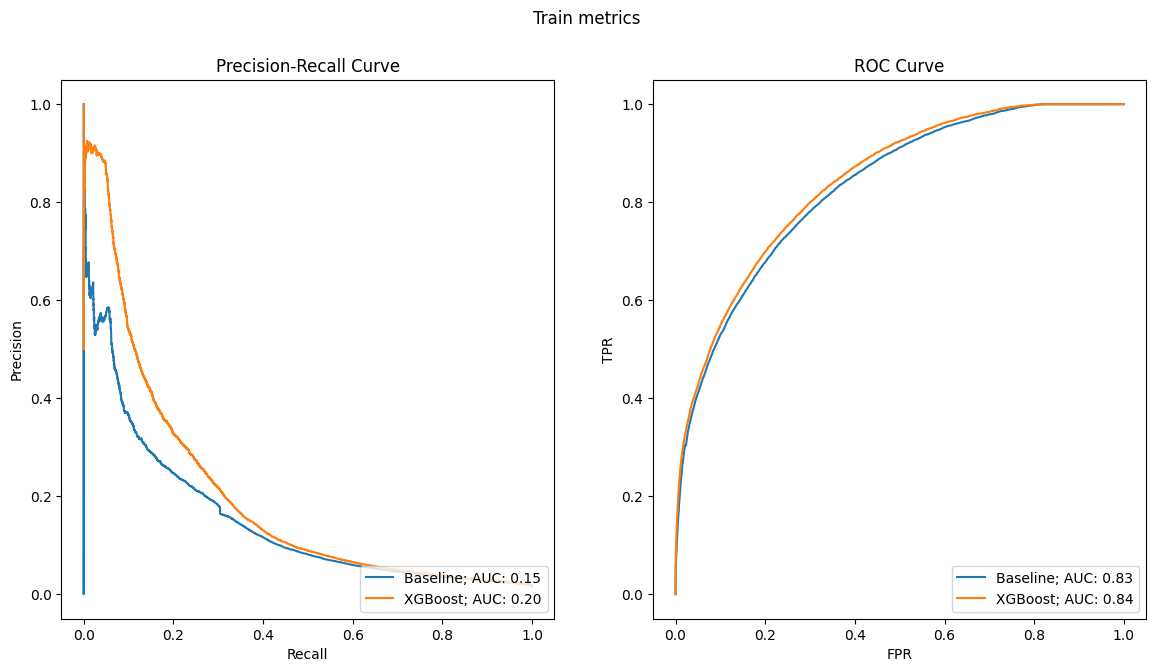

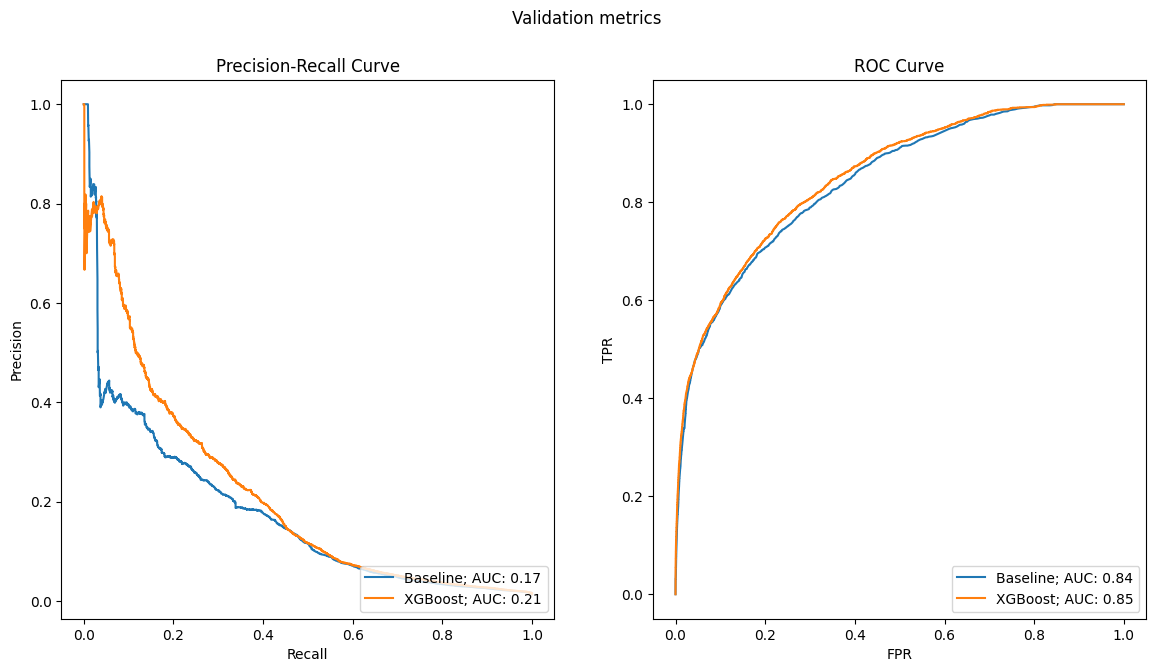

In [37]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))

plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))
plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))

Insights XGBoost:

* There are no significant differences between the initially defined model and the optimized one with hyperparameters. This could be because the initially chosen model was already too good, or because the model's performance does not vary significantly when modifying the hyperparameters.

* Once again, a nonlinear model has been achieved that outperforms the baseline performance.


<h2 style="text-align: left;">Insights</h2>

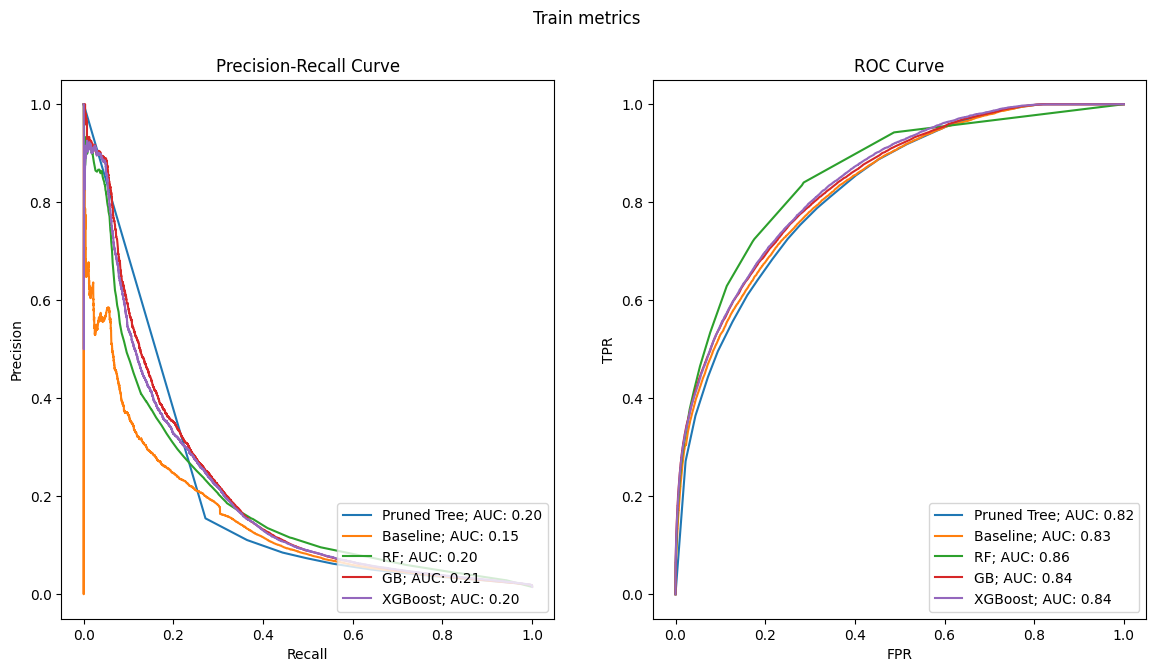

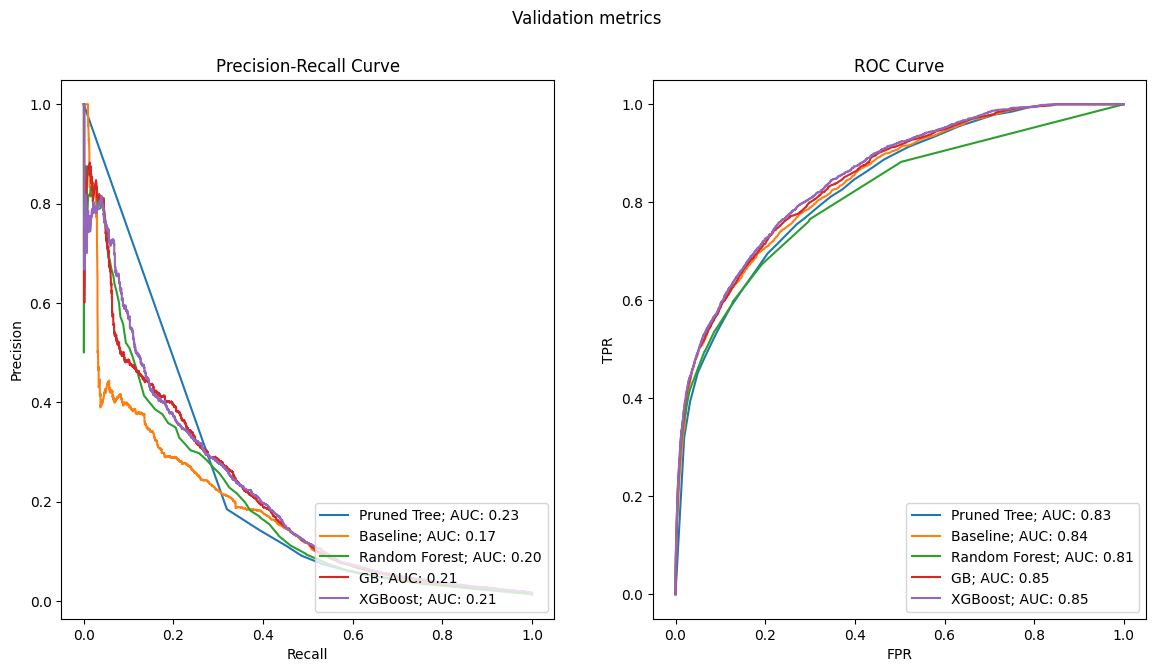

In [41]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validation metrics")

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_train)[:, 1], y_test=y_train, figure=(fig1,ax1))
plot_metrics(f"Baseline", y_pred = baseline_model.predict_proba(X_train_baseline)[:, 1], y_test = y_train_baseline, figure=(fig1,ax1))
plot_metrics(f"RF", y_pred = RF.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))
plot_metrics(f"GB", y_pred = GB.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))
plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_train)[:, 1], y_test = y_train, figure=(fig1,ax1))

plot_metrics(f"Pruned Tree", y_pred=pruned_tree.predict_proba(X_val)[:, 1], y_test=y_val, figure=(fig2,ax2))
plot_metrics(f"Baseline", y_pred = val_proba_baseline, y_test = y_val_baseline, figure=(fig2,ax2))
plot_metrics(f"Random Forest", y_pred = RF.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))
plot_metrics(f"GB", y_pred = GB.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))
plot_metrics(f"XGBoost", y_pred = xgboost.predict_proba(X_val)[:, 1], y_test = y_val, figure=(fig2,ax2))

In [42]:
print(X_train.columns)

Index(['user_order_seq', 'ordered_before', 'abandoned_before',
       'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')
